In [1]:
from datasets import load_dataset
from IPython.display import Audio
ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k")

In [2]:
import soundfile
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [3]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import random
%matplotlib inline

def audio_to_spec(audio, n_fft=1024, hop_length=512):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    mag = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(mag)
    phase=np.angle(stft)
    return mag,phase


def spectrogram_to_audio(magl, phase, sr, n_fft=1024, hop_length=512):
    mag=librosa.db_to_amplitude(magl)
    stft = mag*np.exp(1j * phase) 
    audio = librosa.istft(stft, hop_length=hop_length)
    return audio

In [4]:
#get the waveform of audio
def wplot(arr,title="Waveform",xlab='Time (seconds)',ylab='Amplitude'):
    librosa.display.waveshow(arr, sr=16000)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()


def equal_audio(wav):
    wav=wav[:90000]
    zero_padding=tf.zeros([90000]-tf.shape(wav),dtype=tf.float64)
    wav=tf.concat([zero_padding,wav],0)
    spec=tf.signal.stft(wav,frame_length=320,frame_step=32)
    spec=tf.abs(spec)
    spec=tf.expand_dims(spec,axis=2)
    return spec

#spectogram plot of audio
def spec_plot(spec,title="Spectogram",sr=16000):
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

#check the data array is it consistent or not
def check_data(arr,k=1600):
    cnt=0
    for el in arr:
        if len(el)!=k:
            cnt+=1
        
    return cnt

In [5]:
ds.shape

{'train': (11572, 3), 'test': (824, 3)}

In [7]:
data=ds['train'].select(range(10000))

In [8]:
clean=[]
noisy=[]

for el in data:
    clean.append(np.array(el['clean']['array']))
    noisy.append(np.array(el['noisy']['array']))
    

In [9]:
def get_audio(arr):
    l=len(arr)
    idx=random.randint(0,l)
    print(f"duration of audio {len(clean[idx])/16000}")
    wplot(arr[idx],f"Waveform {idx}")

duration of audio 3.3210625


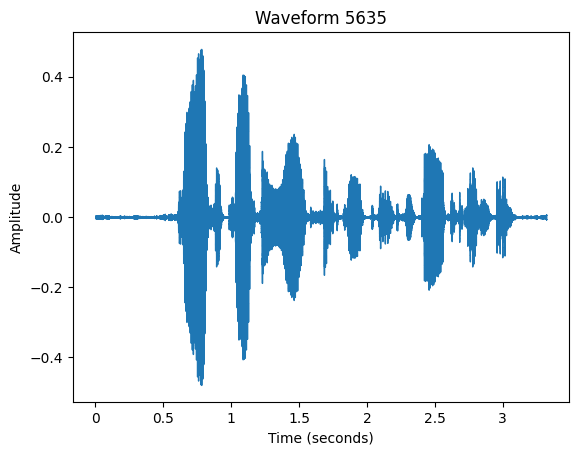

In [10]:
get_audio(clean)

In [11]:
import IPython.display as ipd

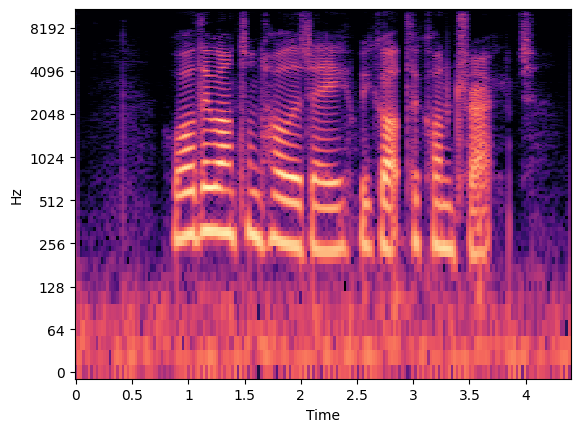

In [12]:
l=len(clean)

idx=random.randint(0,l)

sample_rate=16000
S = np.abs(librosa.stft(clean[idx], n_fft = 1024))
data_inv = librosa.griffinlim(S)

img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
img

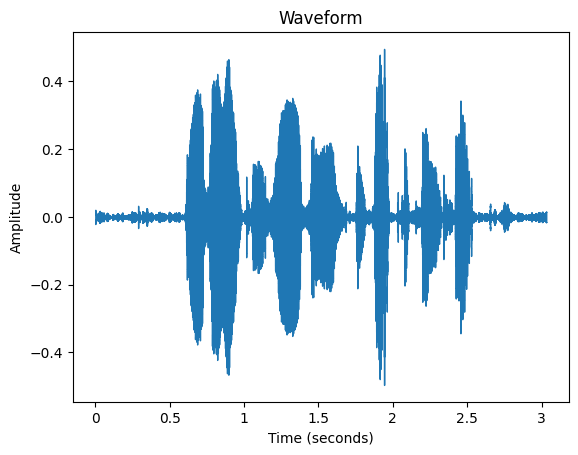

In [13]:
wplot(clean[idx])

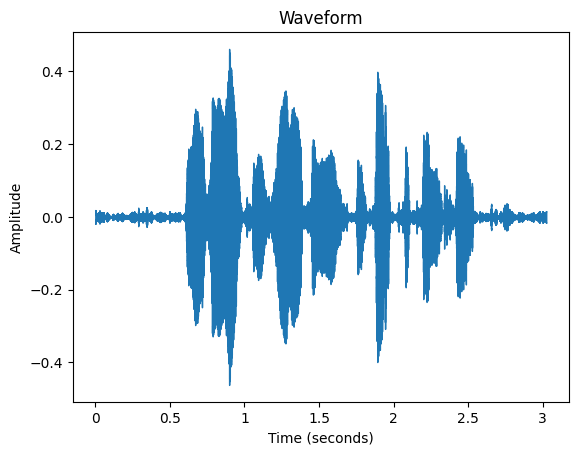

In [14]:
wplot(data_inv)

## we are able to plot and perform transform and re transform to get the audio

In [15]:
Audio(clean[idx],rate=sample_rate)

In [16]:
Audio(data_inv,rate=sample_rate)

In [17]:
brr=clean[idx]
RMS=np.sqrt(np.mean(np.abs(brr**2)))
noise=np.random.normal(0, RMS, brr.shape[0])
brr_noisy = brr+noise

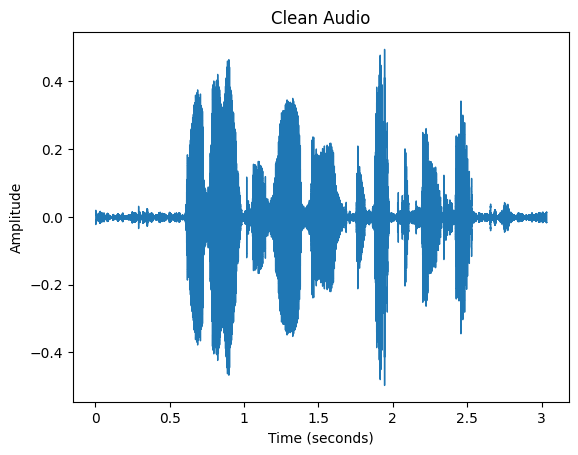

In [18]:
wplot(brr,"Clean Audio")

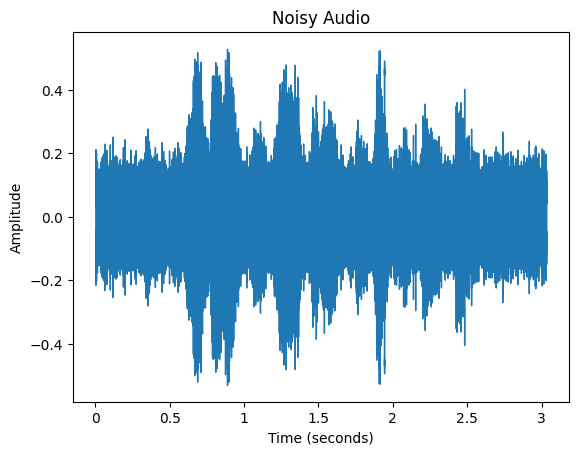

In [19]:
wplot(brr_noisy,"Noisy Audio")

In [20]:
Audio(brr,rate=sample_rate)

In [21]:
Audio(brr_noisy,rate=sample_rate)

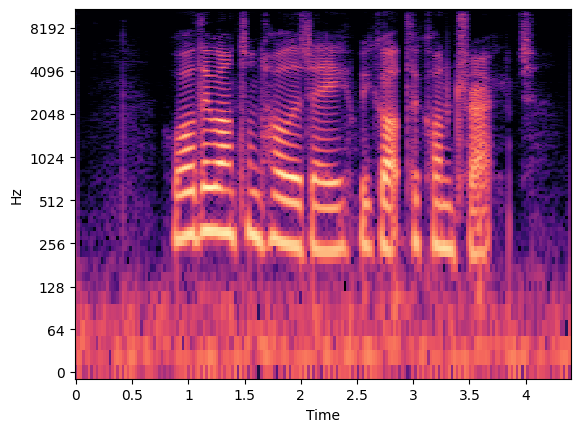

In [22]:
S = np.abs(librosa.stft(brr, n_fft = 1024))
data_inv = librosa.griffinlim(S)

img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
img

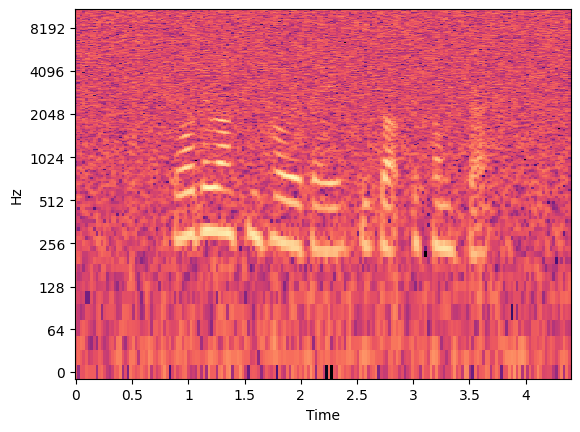

In [23]:
S = np.abs(librosa.stft(brr_noisy, n_fft = 1024))
data_inv = librosa.griffinlim(S)

img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
img

In [24]:
def get_spectrogram_features(filepaths, noise_gain = 0.6, sample_rate = 16000, duration_s = 1):
    '''
    Function to generate features for audio de-noising:
    - Reads from paths to audio files specified in "filepaths" list. 
    - Sets to a fixed length.
    - Generates spectrogram.
    - Adds noise and generates corresponding spectrogram.
    - Outputs clean and noisy spectrogram features.
    '''
    X_clean = []
    X_noisy = []
    
    # Get duration in samples:
    duration = int(sample_rate * duration_s)
    
    for filepath in filepaths:
    
        data=filepath
        
        if len(data) < sample_rate:
            max_offset = np.abs(len(data) - duration)
            offset = np.random.randint(max_offset)
            data = np.pad(data, (offset, duration-len(data)-offset), "constant")
        elif len(data) > sample_rate:
            max_offset = np.abs(len(data) - duration)
            offset = np.random.randint(max_offset)
            data = data[offset:len(data)-max_offset+offset]
        else:
            offset = 0
   
        # Clean spectrogram:
        S = np.abs(librosa.stft(data, n_fft=2048))[:-1,:] 
        # Clean feature array:
        X_clean.append(S)
        
        # noisy spectogram
        RMS=np.sqrt(np.mean(np.abs(data**2)))
        noise=np.random.normal(0, RMS, data.shape[0])
        data_noisy = data+noise
        S_noisy = np.abs(librosa.stft(data_noisy, n_fft=2048))[:-1,:] # Hacky fix to keep the size reconstructable
        X_noisy.append(S_noisy)
    
    # Convert lists to numpy ndarrays:
    X_clean = np.array(X_clean)
    X_clean = np.expand_dims(X_clean, -1)

    # Expand dimensions to be used as input for the model:
    X_noisy = np.array(X_noisy)
    X_noisy = np.expand_dims(X_noisy, -1)
       
    return X_clean, X_noisy

In [25]:
sample_rate = 16000
X_clean, X_noisy = get_spectrogram_features(clean, sample_rate = sample_rate)
spec_shape = (X_clean.shape[1], X_noisy.shape[1])

In [28]:
np.save('clean.npy',X_clean)
np.save('noisy.npy',X_noisy)

In [26]:
spec_shape

(1024, 32)